<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dropout" data-toc-modified-id="Dropout-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dropout</a></span></li><li><span><a href="#Test-Time" data-toc-modified-id="Test-Time-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Test Time</a></span></li><li><span><a href="#Inverted-Dropout" data-toc-modified-id="Inverted-Dropout-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Inverted Dropout</a></span></li><li><span><a href="#Implementing-Inverted-Dropout-from-Scratch" data-toc-modified-id="Implementing-Inverted-Dropout-from-Scratch-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Implementing Inverted Dropout from Scratch</a></span></li><li><span><a href="#Concise-Implementation" data-toc-modified-id="Concise-Implementation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Concise Implementation</a></span></li></ul></div>

## Dropout
The term <b>"dropout"</b> refers to dropping out units in a neural network. It is a technique for addressing overfitting. It consists of randomly dropping out some fraction of the nodes (setting fraction of the units to zero (injecting noise)) in each layer before calculating subsequent layer during training and has become a standard technique for training neural networks. When dropout is applied, during training its zeros out some fraction of the nodes with probability p in each layer before calculating the subsequent layer and the resulting network can be viewed as a subset of the original network. Because the fraction of the nodes that are drop out are chosen randomly on every pass, the representations in each layer can't depend on the exact values taken by nodes in the previous layer. 

<b> Dropout rate</b> is the fraction of the nodes in a layer that are zeroed out and it’s usually set between 0 and 1.

  
 ## Test Time

<b>Typically at test time we disable dropout.</b> Given a trained model and a new example, we do not drop out any nodes and thus do not need to normalize. 
In traditional dropout the weights of the network at test time are scaled versions of the trained weights. If a unit is retained with <b>probability q=1-p</b> during training,S at test time the weights of that unit are multiplied by q.

<img src="images/dropout1.png"/>


## Inverted Dropout

Inverted dropout is a variant of the original dropout technique developed <ahref='papers/JMLRdropout.pdf'>Srivastava et al.(2014)</a>. Just like the traditional dropout, inverted dropout randomly dropp out some fraction of the nodes.

The one difference is that, during training of a neural network using inverted dropout the weights of the network are scaled-down  by the inverse of the keep probability (probability of units retained) q=1-p  and does not need any scaling during test time.

In contrast, traditional dropout requires scaling during the test phase.
<br>
<br><img src="images/invtdrop.png"/>


<img src="images/dropout1.jpg"/>
  (source: From the book am using: Dive into Deep Learning by Aston Zhang, Zachary C. Lipton, Mu Li, and Alexander J. Smola page 162)

for more on dropout read :
<a href='https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf'>Dropout: A Simple Way to Prevent Neural Networks from Overfitting {Srivastava et al.
(2014)}</a>

## Implementing Inverted Dropout from Scratch

In [1]:
import mxnet
import d2l
from mxnet import np,npx,autograd,gluon,init
npx.set_np()

In [2]:
def dropout_layer(X,dropout_rate):
    assert 0<=dropout_rate <=1
    # probability of units to retain
    keep_prob=1-dropout_rate
    # In this case, all elements are dropped out
    if dropout_rate==1:
        return np.zeros_like(X)
    # # In this case, all elements are kept
    if dropout_rate==0:
        return X
    mask=np.random.uniform(low=0.0, high=1.0, size=X.shape)<keep_prob
    return mask.astype(np.float32)*X/keep_prob

testing our dropout function on a few example with probabilities 0, 0.5, and 1, respectively.


In [3]:
X = np.arange(1,17).reshape(2, 8)
X

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12., 13., 14., 15., 16.]])

# dropout all units

In [4]:
dropout_layer(X,1)

array([[0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

# keep all units

In [5]:
dropout_layer(X,0)

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.],
       [ 9., 10., 11., 12., 13., 14., 15., 16.]])

# dropout 0.5  of the units

In [6]:
dropout_layer(X,0.5)

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [18.,  0.,  0., 24., 26., 28.,  0., 32.]])

In [7]:
dropout_layer(X,0.5)

array([[ 0.,  4.,  6.,  8.,  0.,  0.,  0., 16.],
       [ 0., 20.,  0.,  0., 26., 28., 30.,  0.]])

with the 0.5 dropout rate we can the see that the fraction of nodes dropout are random and Because the nodes to drop out are chosen randomly on every pass, the representations in each layer can't depend on the exact values taken by nodes in the previous layer

In [8]:
num_inputs, num_outputs, num_hidden_1,num_hidden_2 = 784, 10, 256, 256

W1 = np.random.normal(scale=0.01, size=(num_inputs, num_hidden_1))
b1 = np.zeros(num_hidden_1)
W2 = np.random.normal(scale=0.01, size=(num_hidden_1, num_hidden_2))
b2 = np.zeros(num_hidden_2)
W3 = np.random.normal(scale=0.01, size=(num_hidden_2, num_outputs))
b3 = np.zeros(num_outputs)

params = [W1, b1, W2, b2, W3, b3]
for param in params:
    param.attach_grad()

In [9]:
def net(X,dropout_prob=0.2):
    X=X.reshape(-1,28*28)
    h1=npx.relu(np.dot(X,W1)+b1)
    if autograd.is_training():
        # apply dropout to the first layer 
        h1=dropout_layer(X=h1,dropout_rate=0.3)
    h2=npx.relu(np.dot(h1,W2)+b2)
    if autograd.is_training():
        # apply dropout to the second layer 
        h2=dropout_layer(h2,dropout_rate=0.5)
    h3=np.dot(h2,W3)+b3
    return h3

In [10]:
num_epochs, lr, batch_size = 10, 0.5, 256
loss = gluon.loss.SoftmaxCrossEntropyLoss()
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

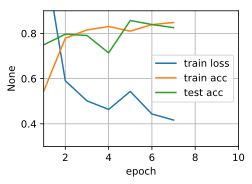

In [ ]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,lambda batch_size: d2l.sgd(params, lr, batch_size))

## Concise Implementation

In [ ]:
net=gluon.nn.Sequential()
with net.name_scope():
    net.add(gluon.nn.Dense(256,activation='relu'))
    net.add(gluon.nn.Dropout(rate=0.3))
    net.add(gluon.nn.Dense(256,activation='relu'))
    net.add(gluon.nn.Dropout(rate=0.5))
    net.add(gluon.nn.Dense(10))

# Parameter initialization

In [ ]:
#net.collect_params().initialize()
#net.initialize(mxnet.init.Normal())
net.initialize(mxnet.init.Xavier(magnitude=2.5))
#net.collect_params().initialze()

In [ ]:
optim=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':0.5})

In [ ]:
loss_fn=gluon.loss.SoftmaxCrossEntropyLoss()

In [ ]:
d2l.train_ch3(net, train_iter, test_iter, loss, num_epochs,lambda batch_size: d2l.sgd(params, lr, batch_size))

In [ ]:
num_epochs, lr, batch_size = 50, 0.5, 256
for epoch in range(num_epochs):
    epoch+=1
    train_loss,val_loss=0,0
    
    for x,y in train_iter:
        with autograd.record():
            y_hat=net(x)
            loss=loss_fn(y_hat,y)
        loss.backward()
        optim.step(batch_size=batch_size)
        train_loss +=loss.mean().asnumpy()
    for x_t,y_t in test_iter:
        pred=net(x_t)
        loss_test=loss_fn(pred,y_t)
        val_loss+=loss_test.mean().asnumpy()
    print("Epoch %d, training loss %f, val loss %f"%(epoch,train_loss,val_loss))